In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import multiprocessing

from scipy.stats import  ttest_rel

from sklearn.model_selection import KFold
from sklearn.metrics import  mean_squared_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.base import BaseEstimator, RegressorMixin

from xgboost import XGBRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import LinearLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast

import wandb

# Preparing Data

In [5]:
ncpus = multiprocessing.cpu_count()
print(f'Number of CPUs: {ncpus}')
n_job=ncpus-2 # decrease number of ncpus job to avoid memory error
print(f'Set number of jobs: {n_job}')
# Cuda Check
if torch.cuda.is_available():
    # Set the default device to the GPU
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print(f"Using CUDA: {torch.cuda.get_device_name(device)}")
else:
    # If GPU not available, use the CPU
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")



Number of CPUs: 20
Set number of jobs: 18
Using CUDA: NVIDIA GeForce RTX 3060 Laptop GPU


In [8]:
df_corr = pd.read_csv('df_corr2.csv', index_col=0)

## Checking years for split

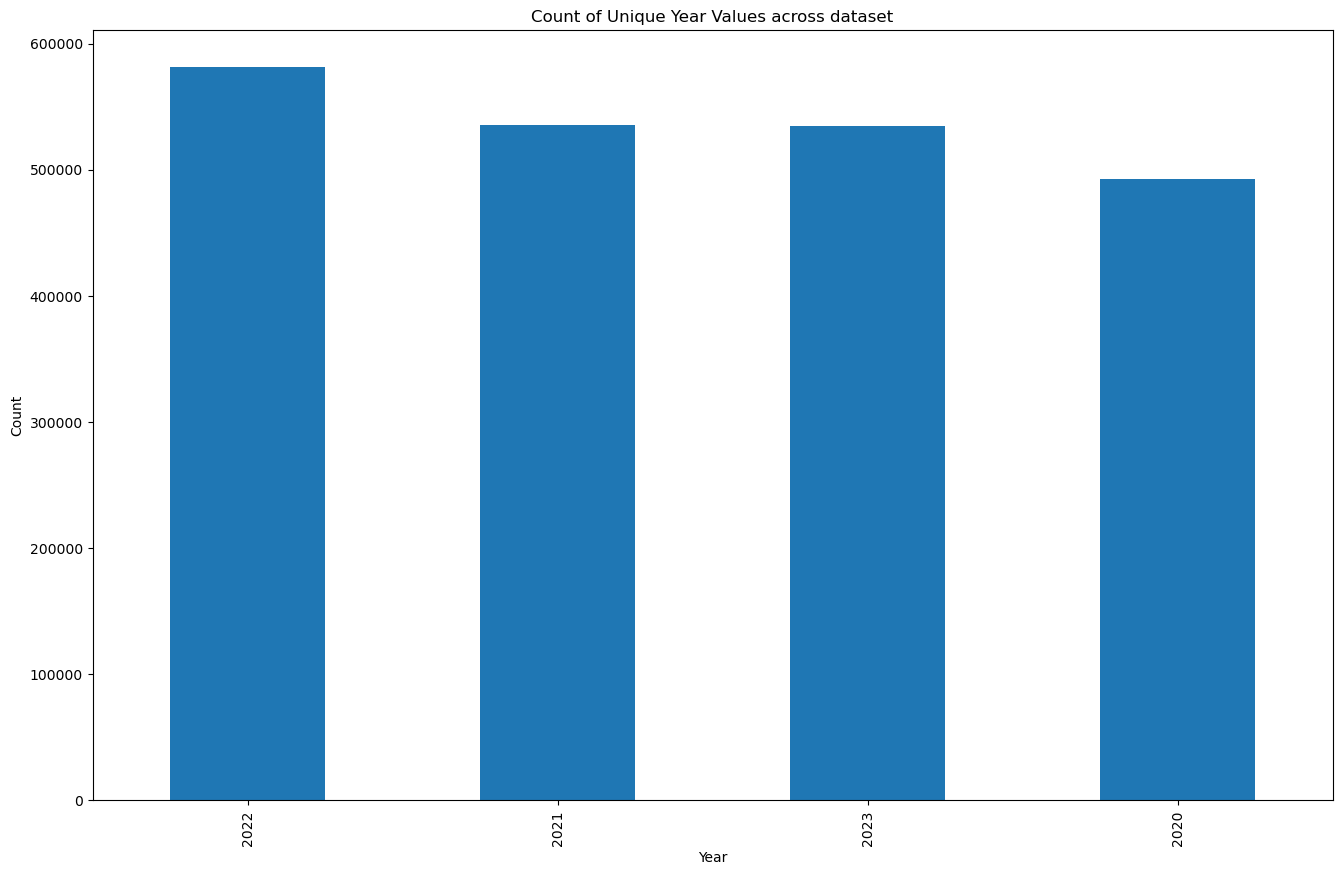

In [9]:
# Count the unique values in the 'year' column
year_counts = df_corr['year'].value_counts()

plt.figure(figsize=(16, 10))
year_counts.plot(kind='bar')

plt.xlabel('Year')
plt.ylabel('Count')

plt.title('Count of Unique Year Values across dataset')
plt.show()

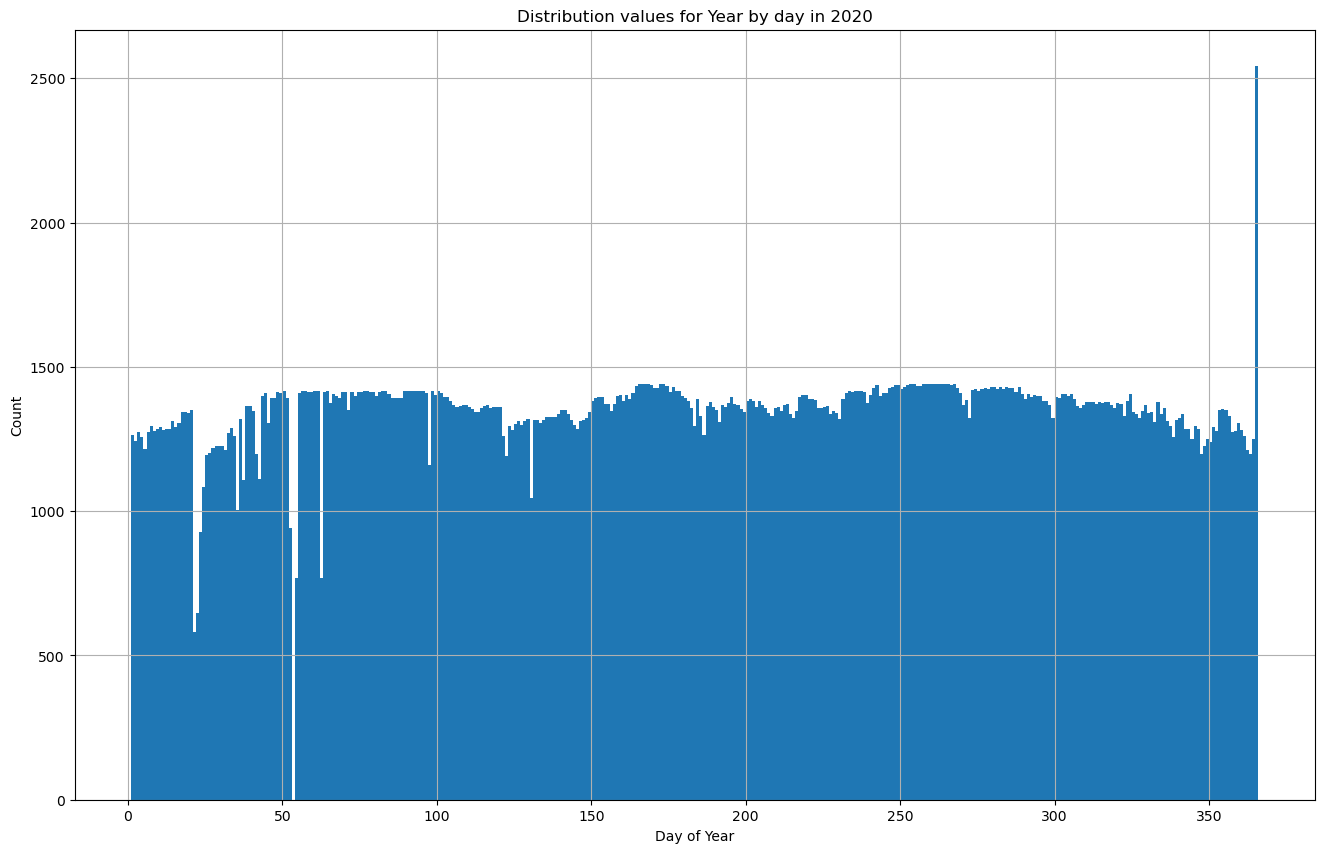

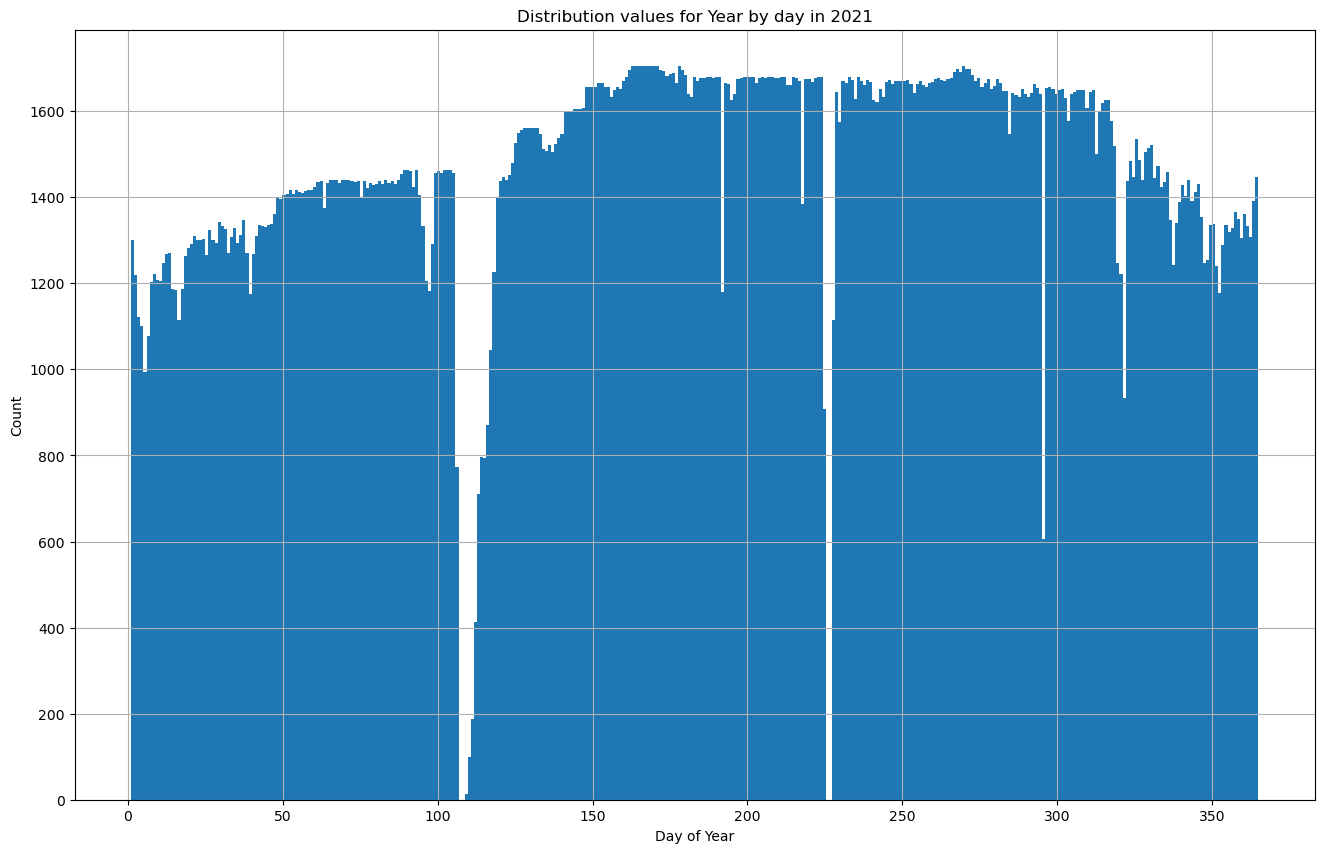

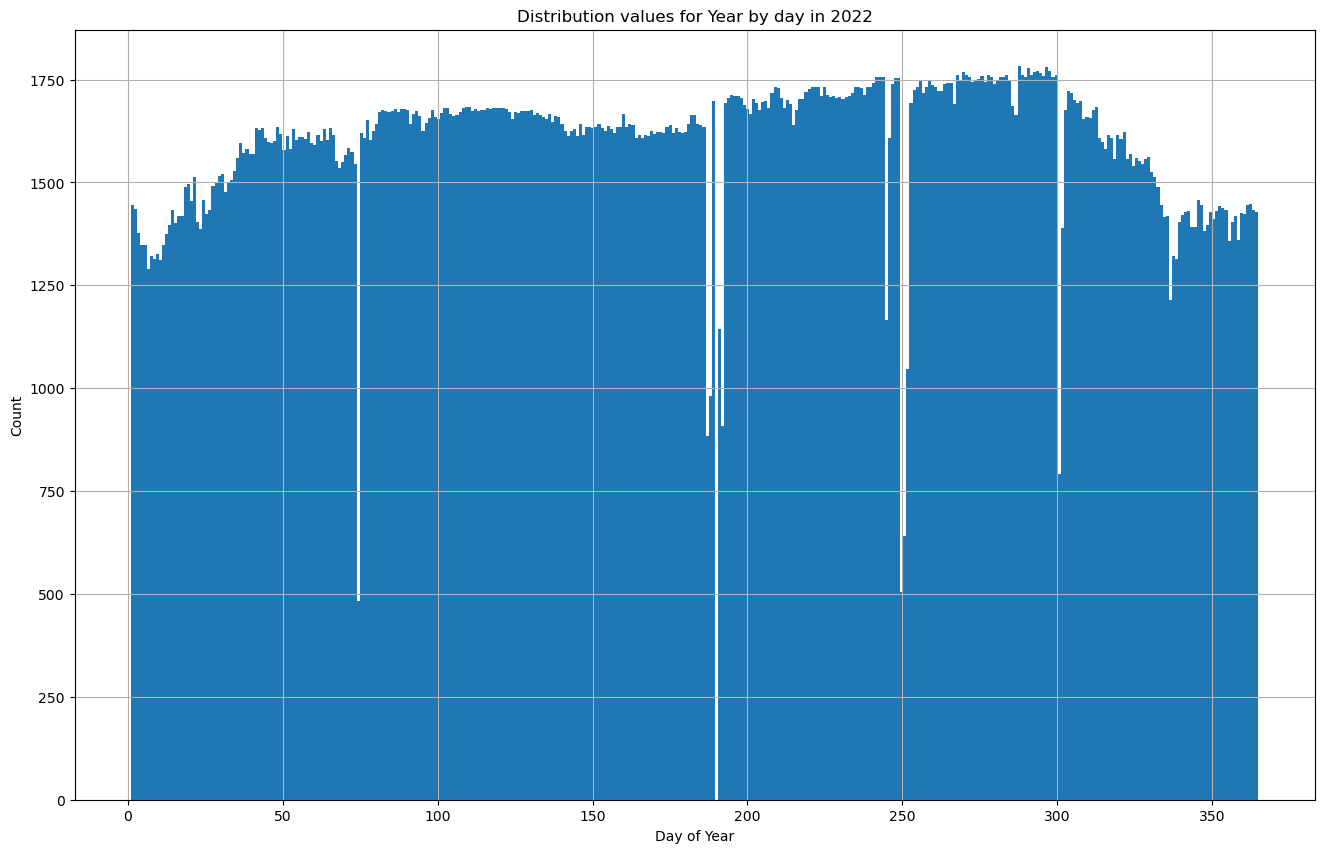

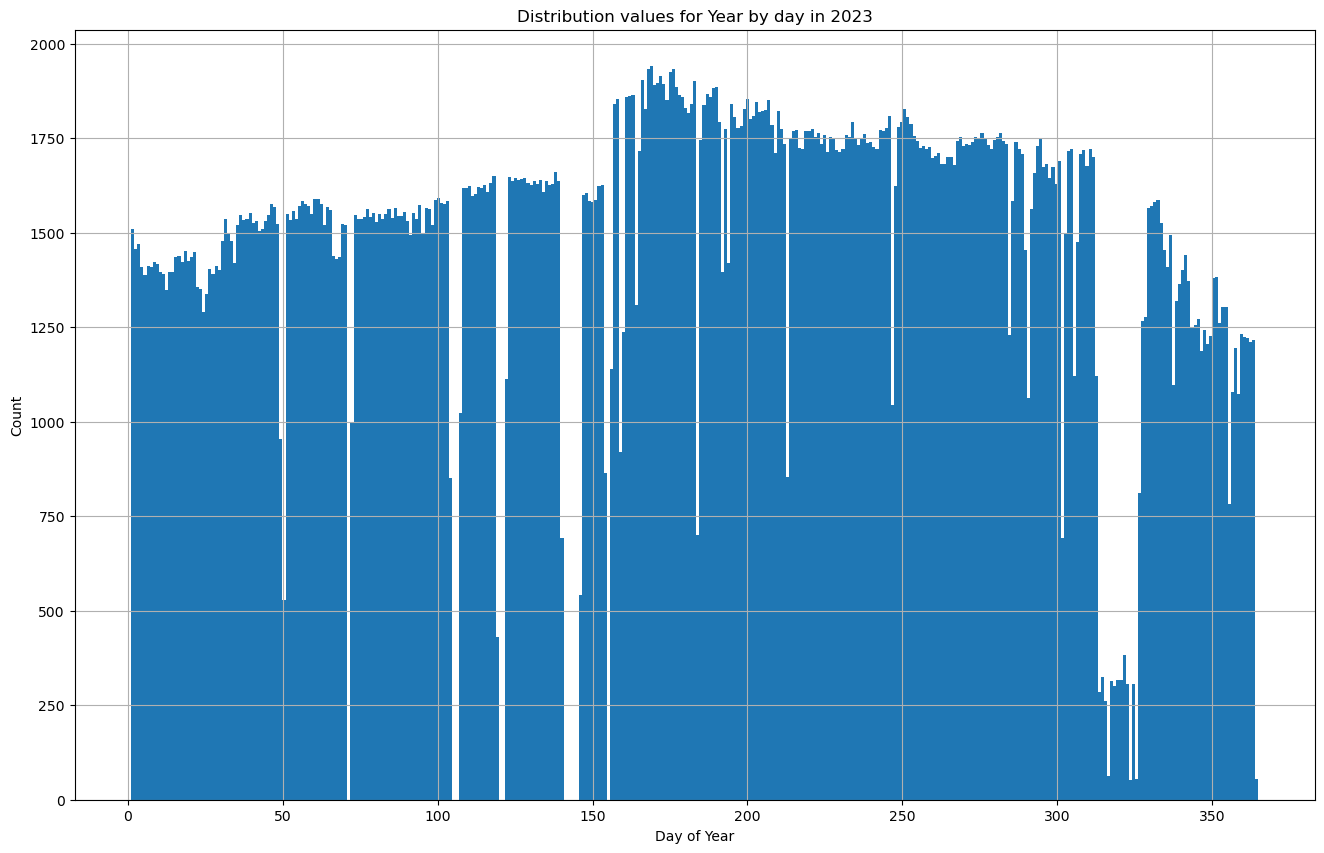

In [10]:
# Get unique years
years = df_corr['year'].unique()

# For each year, plot a histogram
for year in years:
    plt.figure(figsize=(16, 10))
    df_corr[df_corr['year'] == year]['day_of_year'].hist(bins=365)
    plt.title(f'Distribution values for Year by day in {year}')
    plt.xlabel('Day of Year')

    plt.ylabel('Count')
    plt.show()

## Data Splitting

In [11]:
# Change to apply y = PET-temp and add temp to predictions later
pet_temp = True

In [12]:
# Select rows for each year
train = df_corr[df_corr['year'].isin([2020, 2021])]
validation = df_corr[df_corr['year'] == 2022]
test = df_corr[df_corr['year'] == 2023]

if pet_temp == True:
    # Store 'temp' values separately
    temp_validation = validation['temp']
    temp_test = test['temp']
    y_train = train['PET'] - train['temp']
    y_validation = validation['PET'] 
    y_test = test['PET'] 
   
    X_train = train[['wind_speed', 'temp','pressure', 'precip', 'elevation', 'sin_hour_decimal', 'cos_hour_decimal', 'cos_day_of_year','humidity', 'sin_day_of_year']]
    X_validation = validation[['wind_speed', 'temp','pressure', 'precip', 'elevation', 'sin_hour_decimal', 'cos_hour_decimal', 'cos_day_of_year','humidity', 'sin_day_of_year']]
    X_test = test[['wind_speed', 'temp', 'pressure', 'precip', 'elevation', 'sin_hour_decimal', 'cos_hour_decimal', 'cos_day_of_year','humidity', 'sin_day_of_year']]
    
 
else:
    y_train = train['PET'] 
    y_validation = validation['PET'] 
    y_test = test['PET']

    X_train = train[['wind_speed', 'temp','pressure', 'precip', 'elevation', 'sin_hour_decimal', 'cos_hour_decimal', 'cos_day_of_year','humidity', 'sin_day_of_year']]
    X_validation = validation[['wind_speed', 'temp','pressure', 'precip', 'elevation', 'sin_hour_decimal', 'cos_hour_decimal', 'cos_day_of_year','humidity', 'sin_day_of_year']]
    X_test = test[['wind_speed', 'temp', 'pressure', 'precip', 'elevation', 'sin_hour_decimal', 'cos_hour_decimal', 'cos_day_of_year','humidity', 'sin_day_of_year']]

## Checking solar values

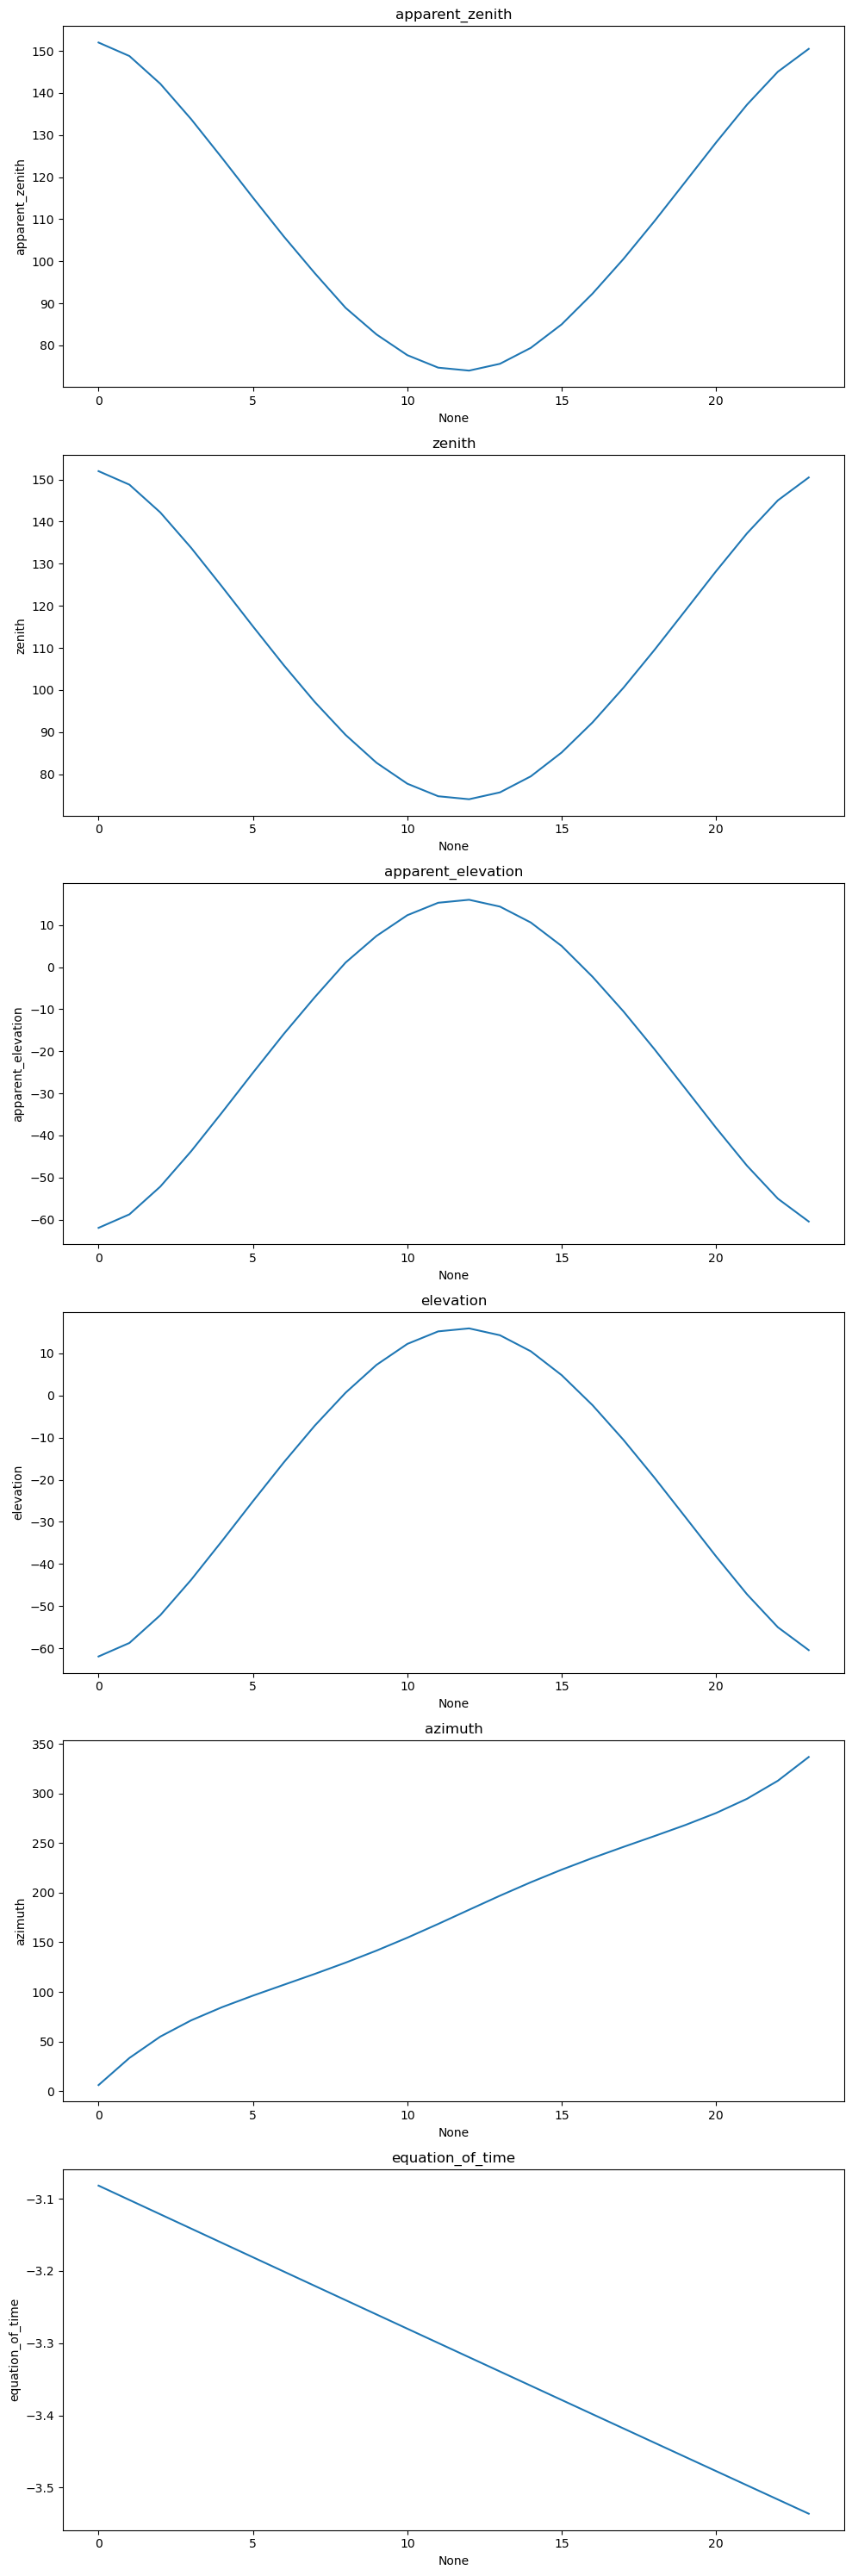

In [13]:
df_subset = df_corr.head(24)

# Columns to plot
columns = ['apparent_zenith', 'zenith', 'apparent_elevation', 'elevation', 'azimuth', 'equation_of_time']

fig, axs = plt.subplots(len(columns), 1, figsize=(10, 5*len(columns)))

# Plot each column
for i, column in enumerate(columns):
    sns.lineplot(data=df_subset, x=df_subset.index, y=column, ax=axs[i])
    axs[i].set_title(column)

plt.tight_layout()
plt.show()

# Training of models preperation

In [22]:
# Project name in wandb
project_name = 'thesis_26.04.2024_pet_manual_split'

Below ere you need to put your login id for wandb 

In [23]:
!wandb login 

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Lukasz\.netrc


Function used for plot Actual vs Predicted values and saving it in wandb and locally

In [24]:
def plot_actual_vs_predicted(y_validation, model, predictions, target_name):
    plt.figure(figsize=(14, 10))
    sns.scatterplot(x=y_validation, y=predictions, s=1)
    sns.lineplot(x=[y_validation.min(), y_validation.max()], y=[y_validation.min(), y_validation.max()], color='black', lw=1)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted for {target_name}, {model}')
    
    # Set limits based on percentiles to avoid extreme outliers
    lower_percentile = 0.5
    upper_percentile = 99.5
    min_val = min(np.percentile(y_validation, lower_percentile), np.percentile(predictions, lower_percentile))
    max_val = max(np.percentile(y_validation, upper_percentile), np.percentile(predictions, upper_percentile))
    
    plt.xlim(min_val-15, max_val+20)
    plt.ylim(min_val-15, max_val+20)
    
    filename = f"predictions_vs_ground_truth_{model}.png"
    plt.savefig(filename)
    wandb.log({"predictions_vs_ground_truth": wandb.Image(filename)})
    plt.show()
    plt.close()

Function to save best predictions base on mse in wandb and locally

In [25]:
def save_and_log_best_predictions(run, mse, best_mse, predictions, model_name):
    if mse < best_mse:
        best_mse = mse  # Update the best MSE found so far.
        # Save and log the best predictions in file and wandb as artifact
        predictions_file = f'best_{model_name}_predictions.npy'
        np.save(predictions_file, predictions)
        predictions_artifact = wandb.Artifact(
            'best_predictions', type='model_predictions',
            description=f'Best {model_name} model predictions',
            metadata={'mse': mse}
        )
        predictions_artifact.add_file(predictions_file)
        run.log_artifact(predictions_artifact)
    return best_mse

## Random Forest sklearn

In [ ]:
# Hyperparameters for sweep configuration
sweep_config = {
    'name': 'RF_Sklearn_Sweep',
    'method': 'grid',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'n_estimators': {
            'values': [30,50,70]
        },
        'max_depth': {
            'values': [8, 11, 13, 14, 15, 16, 17]
        }
    }
}

def train():
    best_mse = float('inf') 
    # Initialize a new wandb run
    with wandb.init(entity='LukaszGawenda', name='random_forest') as run:
        config = wandb.config
        run_name = f"rf_sk max_depth_{config.max_depth}_n_estimators_{config.n_estimators}"
        wandb.run.name = run_name

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestRegressor(max_depth=config.max_depth))
        ])

        pipeline.fit(X_train, y_train)
        rf_predictions = pipeline.predict(X_validation)
   
        if pet_temp == True:
            rf_predictions += temp_validation
         
        mse = mean_squared_error(y_validation, rf_predictions)
        rmse = root_mean_squared_error(y_validation, rf_predictions)

        plot_actual_vs_predicted(y_validation, 'rf', rf_predictions, 'PET')

        # Log metrics in wandb
        wandb.log({
            'rmse': rmse,
            'val_loss': mse  
        })

        best_mse = save_and_log_best_predictions(run, mse, best_mse, rf_predictions, 'rf')

        print(f"Logged an artifact: RandomForest model with MSE: {mse}, RMSE: {rmse}")

sweep_id = wandb.sweep(sweep_config, project=project_name)

Running training in wandb

In [ ]:
wandb.agent(sweep_id, function=train)

## Linear Regression sklearn

In [ ]:
# Hyperparameters for sweep configuration
sweep_config = {
    'name': 'LR_Sklearn_Sweep',
    'method': 'grid',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'fit_intercept': {
            'values': [True]
        }
    }
}

def train():
    best_mse = float('inf')  
    # Initialize a new wandb run
    with wandb.init(entity='LukaszGawenda', name='linear_regression') as run:
        config = wandb.config
        run_name = f"lr_sk fit_intercept_{config.fit_intercept}"
        wandb.run.name = run_name

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LinearRegression(fit_intercept=config.fit_intercept))
        ])

        pipeline.fit(X_train, y_train)
        lr_predictions = pipeline.predict(X_validation)
      
        if pet_temp:
            lr_predictions += temp_validation
            print(f"Predictions+temp: {lr_predictions}")
        mse = mean_squared_error(y_validation, lr_predictions)
        rmse = np.sqrt(mse)
        
        plot_actual_vs_predicted(y_validation, 'lr', lr_predictions, 'PET')
        
        # Log metrics in wandb
        wandb.log({
            'rmse': rmse,
            'val_loss': mse  
        })

        best_mse = save_and_log_best_predictions(run, mse, best_mse, lr_predictions, 'lr')

        print(f"Logged an artifact: LinearRegression model with MSE: {mse}, RMSE: {rmse}")

sweep_id = wandb.sweep(sweep_config, project=project_name)

Running training in wandb

In [ ]:
wandb.agent(sweep_id, function=train)

## MLP sklearn

In [ ]:
# Hyperparameters for sweep configuration
sweep_config = {
    'name': 'MLP_Sklearn_Sweep',
    'method': 'grid',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'hidden_layer_sizes': {
            'values': [[3], [4], [5], [6], [7], [8], [9], [10], [9,10],[10,9], [9,15], [10,15], [9,20], [10,20],[9,25], [10,25], [9,20,5], [10,25,5], [9,20,10], [10,25,10]]
        },
        'activation': {
            'values': ['relu']
        },
        'solver': {
            'values': ['adam']
        },
        'learning_rate_init': {
            'values': [0.001, 0.01]
        },
        'max_iter': {
            'values': [20]
        },
        'early_stopping': {
            'values': [True]
        },
        'n_iter_no_change': {
            'values': [6]
        },
        'batch_size': {
            'values': [32,64]
        }
    }
}


def train():
    best_mse = float('inf')  
    # Initialize a new wandb run
    with wandb.init(entity='LukaszGawenda', name='mlp_regression_sk') as run:
        config = wandb.config
        run_name = f"mlp_sk hidden_layer_sizes_{config.hidden_layer_sizes}_activation_{config.activation}_solver_{config.solver}_learning_rate_init{config.learning_rate_init}_max_iter_{config.max_iter}_early_stopping_{config.early_stopping}_n_iter_no_change_{config.n_iter_no_change}_batch_size_{config.batch_size}"
        wandb.run.name = run_name

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('mlp', MLPRegressor(
                hidden_layer_sizes=config.hidden_layer_sizes,
                activation=config.activation,
                solver=config.solver,
                batch_size=config.batch_size,
                learning_rate_init=config.learning_rate_init,
                max_iter=config.max_iter,
                early_stopping=config.early_stopping,
                n_iter_no_change=config.n_iter_no_change
            ))
        ])

        pipeline.fit(X_train, y_train)
        mlp_model = pipeline.named_steps['mlp']
        mlp_predictions = pipeline.predict(X_validation)
           
        if pet_temp == True:
            mlp_predictions += temp_validation
        mse = mean_squared_error(y_validation, mlp_predictions)
        rmse = np.sqrt(mse)

        plot_actual_vs_predicted(y_validation, 'mlp', mlp_predictions, 'PET')

        # Log metrics in wandb
        wandb.log({
            'rmse': rmse,
            'val_loss': mse,
            'epochs': mlp_model.n_iter_  # Log nr of epochs  
        })

        best_mse = save_and_log_best_predictions(run, mse, best_mse, mlp_predictions, 'mlp')
        # Print for nr of epochs for control
        print(f"Training stopped after {mlp_model.n_iter_} epochs")
        print(f"Logged an artifact: MLPRegressor model with MSE: {mse}, RMSE: {rmse}")

sweep_id = wandb.sweep(sweep_config, project=project_name)

In [ ]:
wandb.agent(sweep_id, function=train)

## XGBoost sklearn

In [ ]:
# Hyperparameters for sweep configuration
sweep_config = {
    'name': 'XGB_Sweep',
    'method': 'grid',  
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'n_estimators': {
            'values': [30,40,50]
        },
        'max_depth': {
            'values': [13,14,15,16,17,18]
        },
    }
}

def train():
    best_mse = float('inf')  
    # Initialize a new wandb run
    with wandb.init( entity='LukaszGawenda', name = 'xgboost') as run:
        config = wandb.config
        run_name = f"xgboost max_depth_{config.max_depth}_n_estimators_{config.n_estimators}"
        wandb.run.name = run_name
       
     
        pipeline = Pipeline([
            ('scaler', StandardScaler()), # not necessary but we do it in mlp so for comparison we do it here as well
            ('xgb', XGBRegressor(
                n_estimators=config.n_estimators,
                max_depth=config.max_depth,
                random_state=42
            ))
        ])

        pipeline.fit(X_train, y_train)
        xgb_predictions = pipeline.predict(X_validation)
           
        if pet_temp == True:
            xgb_predictions += temp_validation
        mse = mean_squared_error(y_validation, xgb_predictions)
        rmse = root_mean_squared_error(y_validation, xgb_predictions)

        plot_actual_vs_predicted(y_validation, 'xgb', xgb_predictions, 'PET')

        # Log metrics in wandb
        wandb.log({
        
            'rmse': rmse,
            'val_loss': mse  
        })

        best_mse = save_and_log_best_predictions(run, mse, best_mse, xgb_predictions, 'xgb')

        print(f"Logged an artifact: XGBoost model with MSE: {mse}, RMSE: {rmse}")


sweep_id = wandb.sweep(sweep_config, project=project_name)

In [ ]:
wandb.agent(sweep_id, function=train)

## MLP Pytorch

Modified save and log best prediction as it operate on tensors

In [50]:
def save_and_log_best_predictions(run, mse, best_mse, predictions, model_name):
    if mse < best_mse:
        best_mse = mse  
        predictions_file = f'best_{model_name}_predictions_torch.npy'
        np.save(predictions_file, predictions.cpu().numpy())  # Ensure predictions are saved as NumPy array
        predictions_artifact = wandb.Artifact(
            'best_predictions', type='model_predictions',
            description=f'Best {model_name} model predictions',
            metadata={'mse': mse}
        )
        predictions_artifact.add_file(predictions_file)
        run.log_artifact(predictions_artifact)
        print('Best predictions saved with MSE:', best_mse)
    return best_mse


Scaling functions for pytorch

In [51]:
def standard_scale(X, mean=None, std=None):
    device = X.device  
    if mean is None:
        mean = X.mean(0, keepdim=True)
    if std is None:
        std = X.std(0, unbiased=False, keepdim=True)
    return (X - mean) / std, mean.to(device), std.to(device)  

def inverse_standard_scale(X, mean, std):

    mean = mean.to(X.device)
    std = std.to(X.device)
    return X * std + mean

def min_max_scale(tensor, min_value=None, max_value=None):
    if min_value is None:
        min_value = torch.min(tensor)
    if max_value is None:
        max_value = torch.max(tensor)
    scaled_tensor = (tensor - min_value) / (max_value - min_value)
    return scaled_tensor, min_value, max_value

def inverse_min_max_scale(tensor, min_value, max_value):
    return tensor * (max_value - min_value) + min_value

Custom Dataset for Pytorch

In [53]:
class PetDataset(Dataset):
    # Load the dataset
    def __init__(self, X, y):
        # Convert the numpy arrays to PyTorch tensors
        self.X = X.clone().detach()
        self.y = y.clone().detach()  

    def __len__(self):
        # Return the number of samples
        return len(self.X)

    def __getitem__(self, idx):
        # Access the pre-converted tensors directly
        X = self.X[idx]
        y = self.y[idx]
        
        return X, y


In [54]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))  
            layers.append(nn.ReLU()) 
            input_size = hidden_size
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)# store all layers in a list and pass it to nn.Sequential for modularity
                
    def forward(self, x):
        x = self.model(x)
        return x
# Save model state 
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

In [1]:
def train():

    wandb.init(entity='LukaszGawenda', project='mlp_pytorch_upgraded')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    wandb.config.update({"device": str(device)})

    # Retrieve hyperparameters from W&B
    config = wandb.config
    learning_rate = config.learning_rate
    hidden_sizes = config.hidden_sizes
    batch_size = config.batch_size
    num_epochs = config.num_epochs
    run_name = f"MLP_lr_{learning_rate}_hidden_sizes_{hidden_sizes}_batch_{batch_size}_epochs_{num_epochs}_std_in_out_earlyStopLROnPlateau"
    wandb.run.name = run_name

    # Convert numpy to tensors
    X_train_tensor = torch.from_numpy(X_train.values).float()
    y_train_tensor = torch.from_numpy(y_train.values).float()
    X_validation_tensor = torch.from_numpy(X_validation.values).float()
    y_validation_tensor = torch.from_numpy(y_validation.values).float()

    # Normalize features using scaler fuctions
    X_train_tensor, X_mean, X_std = standard_scale(X_train_tensor)
    X_validation_tensor, _, _ = standard_scale(X_validation_tensor, X_mean, X_std)  # Use training mean and std

    # Same with labels
    y_train_tensor, y_mean, y_std = standard_scale(y_train_tensor)
    y_validation_tensor, _, _ = standard_scale(y_validation_tensor, y_mean, y_std)

    # Create datasets and dataloaders
    train_dataset = PetDataset(X_train_tensor.clone().detach(), y_train_tensor.clone().detach())
    validation_dataset = PetDataset(X_validation_tensor.clone().detach(), y_validation_tensor.clone().detach())

    # Pin memory is used to speed up the transfer of data to the GPU
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, pin_memory=True)

    # Initializes the model, optimizer, and loss function.
    model = MLP(X_train.shape[1], config.hidden_sizes, 1).to(device)
    optimizer = Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

    # Automatic Mixed Precision to speed up training
    scaler = GradScaler()

    best_val_mse = float('inf')
    patience, trials = 6, 0  # Early stopping criteria
    best_model_saved = False

    for epoch in range(config.num_epochs):
        model.train()
        total_loss = 0
        for features, labels in train_loader: # Training loop
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(features)
                loss = criterion(outputs, labels.view(-1, 1))
            scaler.scale(loss).backward() # Backpropagate loss
            scaler.step(optimizer) # Update model parameters
            scaler.update() # Update scaler for next iteration
            total_loss += loss.item() # Acuumulate loss for each batch

        model.eval()
        all_outputs = []
        all_labels = []
        
        # Validation loop
        with torch.no_grad():
            for features, labels in validation_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                all_outputs.append(outputs)
                all_labels.append(labels)

        all_outputs = torch.cat(all_outputs, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        # Rescale outputs and labels
        all_outputs_rescaled = inverse_standard_scale(all_outputs, y_mean, y_std)
        all_labels_rescaled = inverse_standard_scale(all_labels, y_mean, y_std)


        # Pet temp option
        if pet_temp:
            temp_validation_tensor = torch.from_numpy(temp_validation.values).float().to(device).view(-1, 1)  
            if temp_validation_tensor.shape[0] == all_outputs_rescaled.shape[0]:
                all_outputs_rescaled += temp_validation_tensor
            else:
                raise ValueError("Shape mismatch: temp_validation_tensor and all_outputs_rescaled must have the same number of rows.")

        val_mse = criterion(all_outputs_rescaled, all_labels_rescaled.view(-1, 1)).item()
        rmse = np.sqrt(val_mse)

        # Check if current model is the best so far 
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            checkpoint(model, "best_model.pth")
            # Save predictions for plot later
            np.save("best_MLP_predictions_torch.npy", all_outputs_rescaled.cpu().numpy())
            trials = 0
            best_model_saved = True
            print('epoch, trials and patience, lr', epoch, trials, patience, scheduler.optimizer.param_groups[0]['lr'])
        else:
            trials += 1
            print('epoch, trials and patience, lr', epoch, trials, patience, scheduler.optimizer.param_groups[0]['lr'])
            if trials >= patience:
                print("Early stopping triggered")
                break

        scheduler.step(val_mse)

        wandb.log({
            'epoch': epoch,
            "learning_rate": scheduler.optimizer.param_groups[0]['lr'],
            'train_loss': total_loss / len(train_loader),
            'val_mse': val_mse,
            'rmse': rmse,
            'best_val_mse': best_val_mse  
        })

        best_val_mse = save_and_log_best_predictions(wandb.run, val_mse, best_val_mse, all_outputs_rescaled, "MLP")

    if best_model_saved:
        model.load_state_dict(torch.load("best_model.pth"))
    else:
        print("Best model was not saved. Training may not have improved.")

    plt.figure(figsize=(14, 10))
    plt.scatter(all_labels_rescaled.cpu().numpy(), all_outputs_rescaled.cpu().numpy(), s=1)
    plt.plot([all_labels_rescaled.cpu().min(), all_labels_rescaled.cpu().max()], [all_labels_rescaled.cpu().min(), all_labels_rescaled.cpu().max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    
    min_val = min(all_labels_rescaled.cpu().min(), all_outputs_rescaled.cpu().min())
    max_val = max(all_labels_rescaled.cpu().max(), all_outputs_rescaled.cpu().max())
    plt.xlim([min_val, max_val])
    plt.ylim([min_val, max_val])
    
    plt.savefig("actual_vs_predicted.png")
    wandb.log({"actual_vs_predicted": wandb.Image("actual_vs_predicted.png")})
    wandb.finish()



In [ ]:
# Define mlp hyperparameters for sweep
sweep_config = {
    'name': 'MLP_Sweep',
    'method': 'grid',
    'metric': {
        'name': 'val_mse',
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.01, 0.001] 
        },
        'hidden_sizes': {
            'values': [[3], [4], [5], [6], [7], [8], [9], [10], [9,10],[10,9], [9,15], [10,15], [9,20], [10,20],[9,25], [10,25], [10,20,5],[9,25,5], [10,20,10],[9,25,10]]
        },
        'batch_size': {
            'values': [32,64] 
        },
        'num_epochs': {
            'value': 20
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)
wandb.agent(sweep_id, train)

# Student T-Test Predcitons of Best Models

## PET

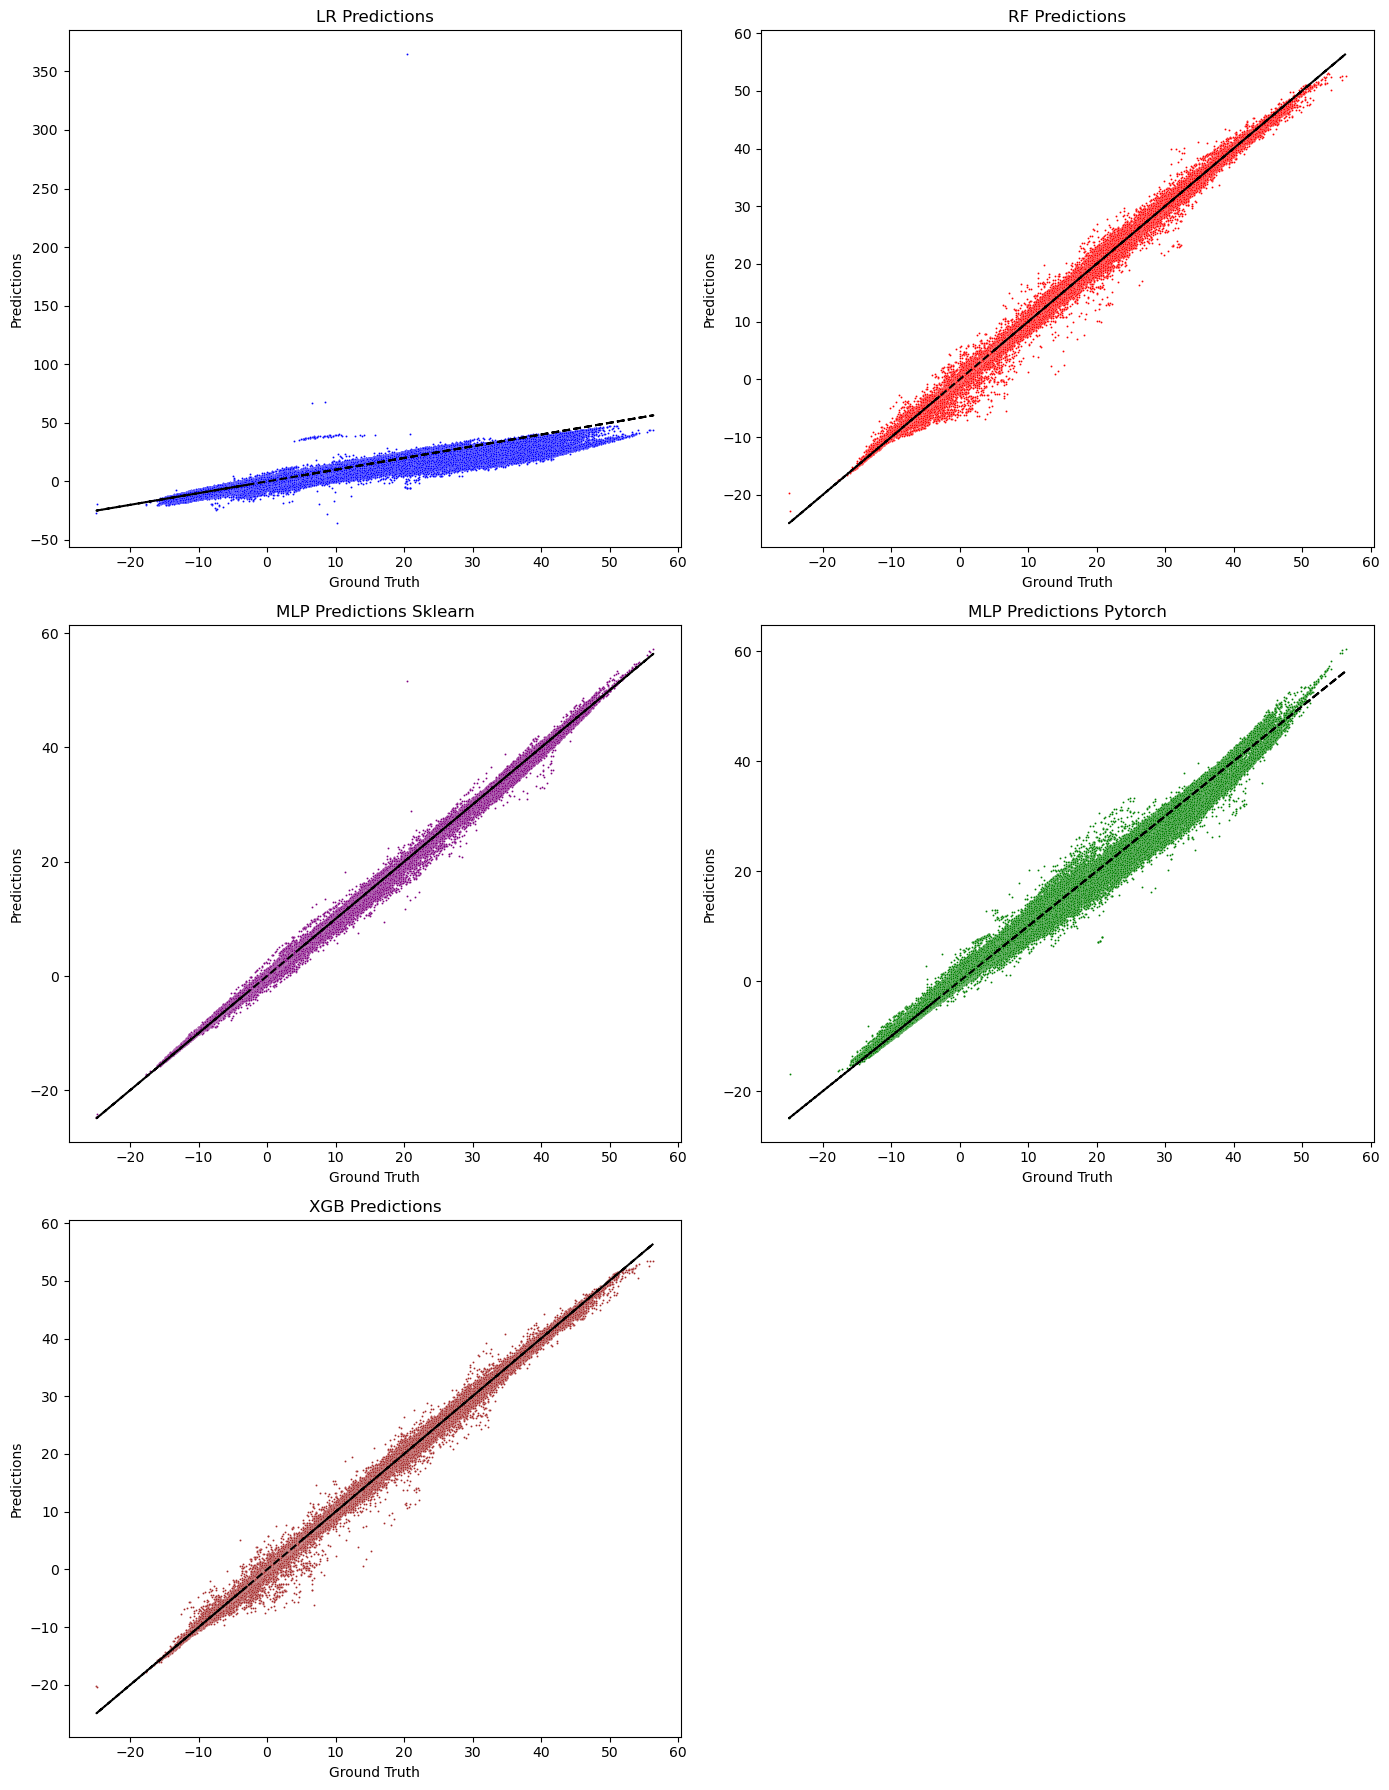

In [57]:
# Load the predictions
folder_path = 'D:/Vub/Thesis/Programming/ML/WholeDatalML/'
rf_predictions = np.load(folder_path + 'best_rf_predictions.npy')
lr_predictions = np.load(folder_path + 'best_lr_predictions.npy')
mlp_predictions = np.load(folder_path + 'best_mlp_predictions.npy')
mlp_torch_predictions = np.load(folder_path + 'best_MLP_predictions_torch.npy')
xgb_predictions = np.load(folder_path + 'best_xgb_predictions.npy')

fig, axs = plt.subplots(3, 2, figsize=(14, 18))
# The radius of the scatter points
s=2

sns.scatterplot(x=y_validation, y=lr_predictions, s=s, ax=axs[0, 0], color='blue')
axs[0, 0].plot(y_validation, y_validation, 'k--')
axs[0, 0].set_title('LR Predictions')
axs[0, 0].set_xlabel('Ground Truth')
axs[0, 0].set_ylabel('Predictions')

sns.scatterplot(x=y_validation, y=rf_predictions, s=s, ax=axs[0, 1], color='red')
axs[0, 1].plot(y_validation, y_validation, 'k--')
axs[0, 1].set_title('RF Predictions')
axs[0, 1].set_xlabel('Ground Truth')
axs[0, 1].set_ylabel('Predictions')


sns.scatterplot(x=y_validation, y=mlp_predictions, s=s, ax=axs[1, 0], color='purple')
axs[1, 0].plot(y_validation, y_validation, 'k--')
axs[1, 0].set_title('MLP Predictions Sklearn')
axs[1, 0].set_xlabel('Ground Truth')
axs[1, 0].set_ylabel('Predictions')


sns.scatterplot(x=y_validation, y=mlp_torch_predictions.flatten(), s=s, ax=axs[1, 1], color='green')
axs[1, 1].plot(y_validation, y_validation, 'k--')
axs[1, 1].set_title('MLP Predictions Pytorch')
axs[1, 1].set_xlabel('Ground Truth')
axs[1, 1].set_ylabel('Predictions')


sns.scatterplot(x=y_validation, y=xgb_predictions, s=s, ax=axs[2, 0], color='brown')
axs[2, 0].plot(y_validation, y_validation, 'k--')
axs[2, 0].set_title('XGB Predictions')
axs[2, 0].set_xlabel('Ground Truth')
axs[2, 0].set_ylabel('Predictions')

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()

Wrapping the Pytorch MLP model for the similar functionality as sklearn ones and to use fit and predict in the Student T-Test.

In [62]:

class PyTorchMLPWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, hidden_sizes, learning_rate=0.01, epochs=20, batch_size=64, patience=6, random_state=None):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.patience = patience
        self.random_state = random_state
        self.model = None
        self.mean_X = None
        self.std_X = None
        self.mean_y = None
        self.std_y = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def _build_model(self):
        layers = []
        in_dim = self.input_size
        for hidden_size in self.hidden_sizes:
            layers.append(nn.Linear(in_dim, hidden_size))
            layers.append(nn.ReLU())
            in_dim = hidden_size
        layers.append(nn.Linear(in_dim, 1))
        model = nn.Sequential(*layers)
        return model

    def fit(self, X, y, X_val=None, y_val=None):
        if self.random_state:
            torch.manual_seed(self.random_state)
        self.model = self._build_model()
        self.model.to(self.device)  
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
        scaler = GradScaler()

        X_tensor = torch.tensor(X.values, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32).to(self.device)

        X_scaled, self.mean_X, self.std_X = standard_scale(X_tensor)
        y_scaled, self.mean_y, self.std_y = standard_scale(y_tensor)

        dataset = TensorDataset(X_scaled, y_scaled)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        if X_val is not None and y_val is not None:
            X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(self.device)
            y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32).to(self.device)

            X_val_scaled, _, _ = standard_scale(X_val_tensor, self.mean_X, self.std_X)
            y_val_scaled, _, _ = standard_scale(y_val_tensor, self.mean_y, self.std_y)

            val_loader = DataLoader(TensorDataset(X_val_scaled, y_val_scaled), batch_size=self.batch_size)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            self.model.train()
            total_loss = 0
            for features, labels in loader:
                features, labels = features.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                with autocast():
                    outputs = self.model(features)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                total_loss += loss.item()

            if X_val is not None and y_val is not None:
                self.model.eval()
                all_outputs = []
                all_labels = []
                with torch.no_grad():
                    for features, labels in val_loader:
                        features, labels = features.to(self.device), labels.to(self.device)
                        outputs = self.model(features)
                        all_outputs.append(outputs)
                        all_labels.append(labels)

                all_outputs = torch.cat(all_outputs, dim=0)
                all_labels = torch.cat(all_labels, dim=0)

                all_outputs_rescaled = inverse_standard_scale(all_outputs, self.mean_y, self.std_y)
                all_labels_rescaled = inverse_standard_scale(all_labels, self.mean_y, self.std_y)

                val_loss = criterion(all_outputs_rescaled, all_labels_rescaled)
                scheduler.step(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.patience:
                    print("Early stopping triggered")
                    break

            print(f'Epoch {epoch+1}/{self.epochs}, Loss: {total_loss/len(loader):.4f}, Val Loss: {val_loss:.4f}, Patience: {patience_counter}')

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X.values, dtype=torch.float32).to(self.device)
        X_scaled, _, _ = standard_scale(X_tensor, self.mean_X, self.std_X)
        with torch.no_grad():
            predictions = self.model(X_scaled)
        return inverse_standard_scale(predictions, self.mean_y, self.std_y).cpu().numpy().flatten()


## Student T-Test PET Result

In [64]:

# K-fold cross-validation for Student t-test we dont shuffle to not snoop data
kfold = KFold(n_splits=10, shuffle=False)

rmse_dict = {}

# Best Models to evaluate
models = {
    'xgboost': XGBRegressor(n_estimators=13, max_depth=50, random_state=42),
    'linear_regressor': LinearRegression(fit_intercept=True),
    'mlp': MLPRegressor(
    hidden_layer_sizes=[9, 20, 10],
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=20,
    early_stopping=True,
    n_iter_no_change=6,
    batch_size=32,
    random_state=42),
    'random_forest': RandomForestRegressor(n_estimators=30, max_depth=17, random_state=42),
    'mlp_pytorch': PyTorchMLPWrapper(input_size=X_train.shape[1], hidden_sizes=[9, 10], learning_rate=0.01, epochs=20, batch_size=64, patience=6, random_state=42)
}

for model_name, model in models.items():
    rmse_values = []
    for train_index, val_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        if model_name == 'mlp_pytorch':
            model.fit(X_train_fold, y_train_fold, X_val=X_val_fold, y_val=y_val_fold)
            predictions = model.predict(X_validation)
            print('predictions',predictions)
        else:
             
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', model)
            ])
            pipeline.fit(X_train_fold, y_train_fold)

            # Here I use full year validation set
            predictions = pipeline.predict(X_validation)
        if pet_temp == True:
                predictions += temp_validation
      
        rmse = root_mean_squared_error(y_validation, predictions)
        rmse_values.append(rmse)
    

    rmse_dict[f'{model_name}_kfold'] = rmse_values


rmse_df = pd.DataFrame(rmse_dict)

# Storing P-values
p_values_matrix = pd.DataFrame(np.ones((len(models), len(models))), index=models.keys(), columns=models.keys())

model_names = list(models.keys())


d:\Users\Lukasz\anaconda3\envs\mlenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Users\Lukasz\anaconda3\envs\mlenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1/20, Loss: 0.0103, Val Loss: 0.3526, Patience: 0
Epoch 2/20, Loss: 0.0042, Val Loss: 0.3344, Patience: 0
Epoch 3/20, Loss: 0.0042, Val Loss: 0.1748, Patience: 0
Epoch 4/20, Loss: 0.0038, Val Loss: 0.1945, Patience: 1
Epoch 5/20, Loss: 0.0033, Val Loss: 0.2133, Patience: 2
Epoch 6/20, Loss: 0.0029, Val Loss: 0.1808, Patience: 3
Epoch 7/20, Loss: 0.0015, Val Loss: 0.1132, Patience: 0
Epoch 8/20, Loss: 0.0015, Val Loss: 0.1181, Patience: 1
Epoch 9/20, Loss: 0.0014, Val Loss: 0.1306, Patience: 2
Epoch 10/20, Loss: 0.0015, Val Loss: 0.1176, Patience: 3
Epoch 11/20, Loss: 0.0014, Val Loss: 0.1086, Patience: 0
Epoch 12/20, Loss: 0.0013, Val Loss: 0.1082, Patience: 0
Epoch 13/20, Loss: 0.0013, Val Loss: 0.1085, Patience: 1
Epoch 14/20, Loss: 0.0014, Val Loss: 0.1095, Patience: 2
Epoch 15/20, Loss: 0.0014, Val Loss: 0.1092, Patience: 3
Epoch 16/20, Loss: 0.0013, Val Loss: 0.1084, Patience: 4
Epoch 17/20, Loss: 0.0013, Val Loss: 0.1083, Patience: 5
Early stopping triggered
predictions [ 5

Plotting heat maps and rmse distributions

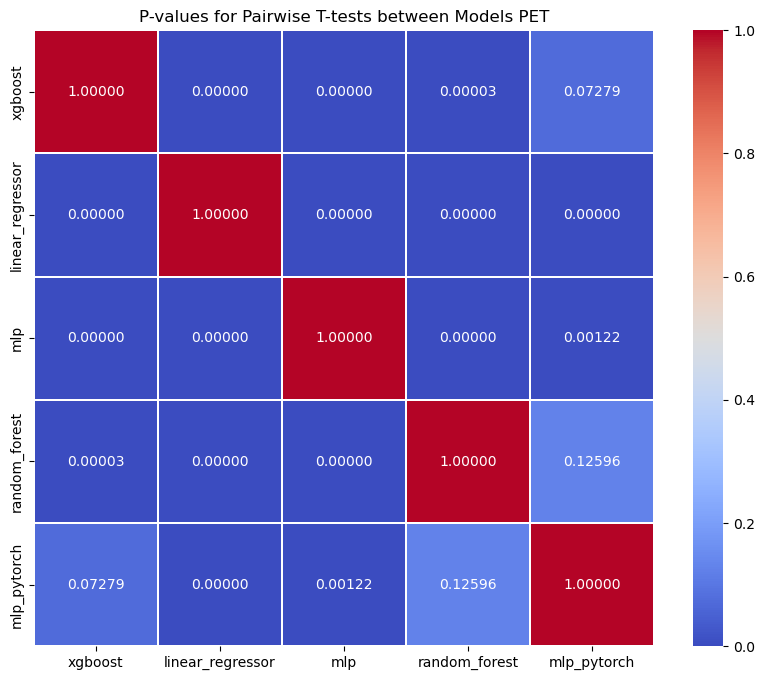

In [72]:
for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)):
        model_1 = f'{model_names[i]}_kfold'
        model_2 = f'{model_names[j]}_kfold'
        t_stat, p_value = ttest_rel(rmse_df[model_1], rmse_df[model_2])
        p_values_matrix.at[model_names[i], model_names[j]] = p_value
        p_values_matrix.at[model_names[j], model_names[i]] = p_value

# Plot the p-values as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_values_matrix, annot=True, cmap="coolwarm", cbar=True, linewidths=.20, fmt=".5f")
plt.title('P-values for Pairwise T-tests between Models PET')
plt.show()

In [67]:
# Saving the results
with open("p_values_dict_pet", 'wb') as file:
    pickle.dump(p_values_matrix, file)
with open("rmse_dict_pet", 'wb') as file:
    pickle.dump(rmse_dict, file)

# PET-TEMP

In [ ]:
# Load the predictions
folder_path = 'D:/Vub/Thesis/Programming/ML/WholeDatalML/PET-Temp/'
rf_predictions = np.load(folder_path + 'best_rf_predictions.npy')
lr_predictions = np.load(folder_path + 'best_lr_predictions.npy')
mlp_predictions = np.load(folder_path + 'best_mlp_predictions.npy')
mlp_torch_predictions = np.load(folder_path + 'best_MLP_predictions_torch.npy')
xgb_predictions = np.load(folder_path + 'best_xgb_predictions.npy')

fig, axs = plt.subplots(3, 2, figsize=(14, 18))
# The radius of the scatter points
s=2

sns.scatterplot(x=y_validation, y=lr_predictions, s=s, ax=axs[0, 0], color='blue')
axs[0, 0].plot(y_validation, y_validation, 'k--')
axs[0, 0].set_title('LR Predictions')
axs[0, 0].set_xlabel('Ground Truth')
axs[0, 0].set_ylabel('Predictions')


sns.scatterplot(x=y_validation, y=rf_predictions, s=s, ax=axs[0, 1], color='red')
axs[0, 1].plot(y_validation, y_validation, 'k--')
axs[0, 1].set_title('RF Predictions')
axs[0, 1].set_xlabel('Ground Truth')
axs[0, 1].set_ylabel('Predictions')

sns.scatterplot(x=y_validation, y=mlp_predictions, s=s, ax=axs[1, 0], color='purple')
axs[1, 0].plot(y_validation, y_validation, 'k--')
axs[1, 0].set_title('MLP Predictions Sklearn')
axs[1, 0].set_xlabel('Ground Truth')
axs[1, 0].set_ylabel('Predictions')


sns.scatterplot(x=y_validation, y=mlp_torch_predictions, s=s, ax=axs[1, 1], color='green')
axs[1, 1].plot(y_validation, y_validation, 'k--')
axs[1, 1].set_title('MLP Predictions Pytorch')
axs[1, 1].set_xlabel('Ground Truth')
axs[1, 1].set_ylabel('Predictions')


sns.scatterplot(x=y_validation, y=xgb_predictions, s=s, ax=axs[2, 0], color='brown')
axs[2, 0].plot(y_validation, y_validation, 'k--')
axs[2, 0].set_title('XGB Predictions')
axs[2, 0].set_xlabel('Ground Truth')
axs[2, 0].set_ylabel('Predictions')

axs[2, 1].axis('off')

plt.tight_layout()

plt.show()

## Student T-Test PET-Temp

In [ ]:
# K-fold cross-validation for Student t-test we dont shuffle to not snoop data
kfold = KFold(n_splits=10, shuffle=False)


rmse_dict = {}
# Best models to evaluate
models = {
    'xgboost': XGBRegressor(n_estimators=13, max_depth=50, random_state=42),
    'linear_regressor': LinearRegression(fit_intercept=True),
    'mlp': MLPRegressor(
    hidden_layer_sizes=[9, 20, 10],
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=20,
    early_stopping=True,
    n_iter_no_change=6,
    batch_size=32,
    random_state=42),
    'random_forest': RandomForestRegressor(n_estimators=30, max_depth=17, random_state=42),
    'mlp_pytorch': PyTorchMLPWrapper(input_size=X_train.shape[1], hidden_sizes=[9, 10], learning_rate=0.01, epochs=20, batch_size=64, patience=6, random_state=42)
}

for model_name, model in models.items():
    rmse_values = []
    for train_index, val_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        if model_name == 'mlp_pytorch':
            model.fit(X_train_fold, y_train_fold, X_val=X_val_fold, y_val=y_val_fold)
            predictions = model.predict(X_validation)
            print('predictions',predictions)
        else:
             
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', model)
            ])
            pipeline.fit(X_train_fold, y_train_fold)

            # Here I use full year validation set
            predictions = pipeline.predict(X_validation)
        if pet_temp == True:
                predictions += temp_validation
       
        rmse = root_mean_squared_error(y_validation, predictions)
        rmse_values.append(rmse)
    
 
    rmse_dict[f'{model_name}_kfold'] = rmse_values


rmse_df = pd.DataFrame(rmse_dict)


p_values_matrix = pd.DataFrame(np.ones((len(models), len(models))), index=models.keys(), columns=models.keys())


model_names = list(models.keys())


Saving results and loading them 

In [ ]:
with open("p_values_dict_pet_temp", 'wb') as file:
    pickle.dump(p_values_matrix, file)
with open("rmse_dict_pet_temp", 'wb') as file:
    pickle.dump(rmse_dict, file)

In [ ]:
with open("rmse_dict_pet_temp", 'rb') as file:
    rmse_dict = pickle.load(file)
with open("p_values_dict_pet_temp", 'rb') as file:
    p_values_pet_temp = pickle.load(file)

Plotting heat maps and rmse distributions

In [ ]:
for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)):
        model_1 = f'{model_names[i]}_kfold'
        model_2 = f'{model_names[j]}_kfold'
        t_stat, p_value = ttest_rel(rmse_df[model_1], rmse_df[model_2])
        p_values_matrix.at[model_names[i], model_names[j]] = p_value
        p_values_matrix.at[model_names[j], model_names[i]] = p_value


plt.figure(figsize=(10, 8))
sns.heatmap(p_values_matrix, annot=True, cmap="coolwarm", cbar=True, linewidths=.20, fmt=".5f")
plt.title('P-values for Pairwise T-tests between Models')
plt.show()

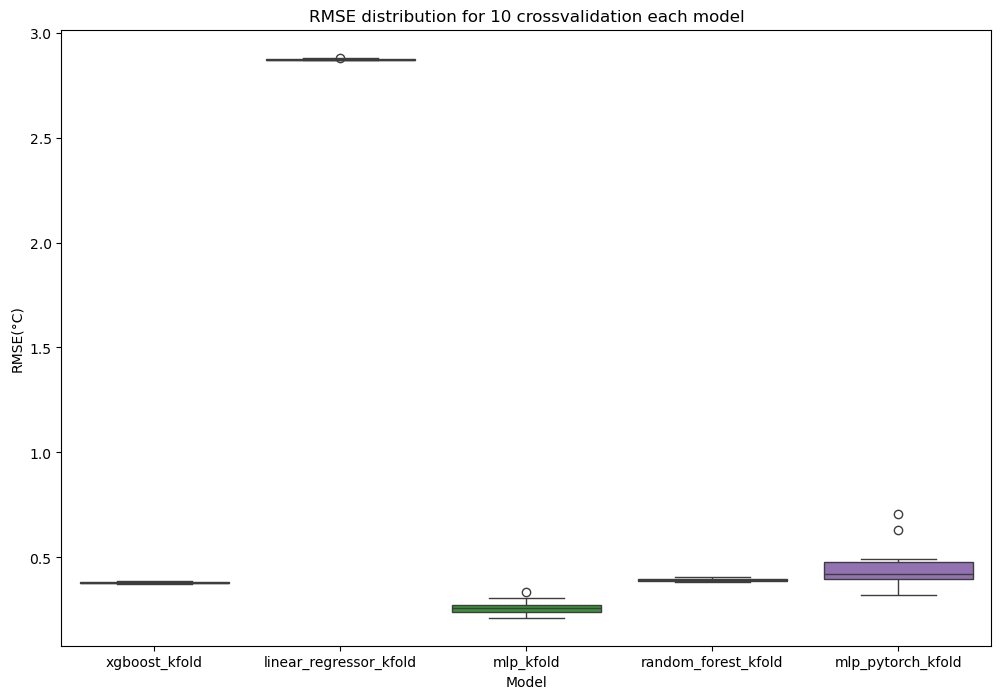

In [68]:
# Plot the MSE values as a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=rmse_df)
plt.title('RMSE distribution for 10 crossvalidation each model')
plt.xlabel('Model')
plt.ylabel('RMSE(°C)')
plt.show()

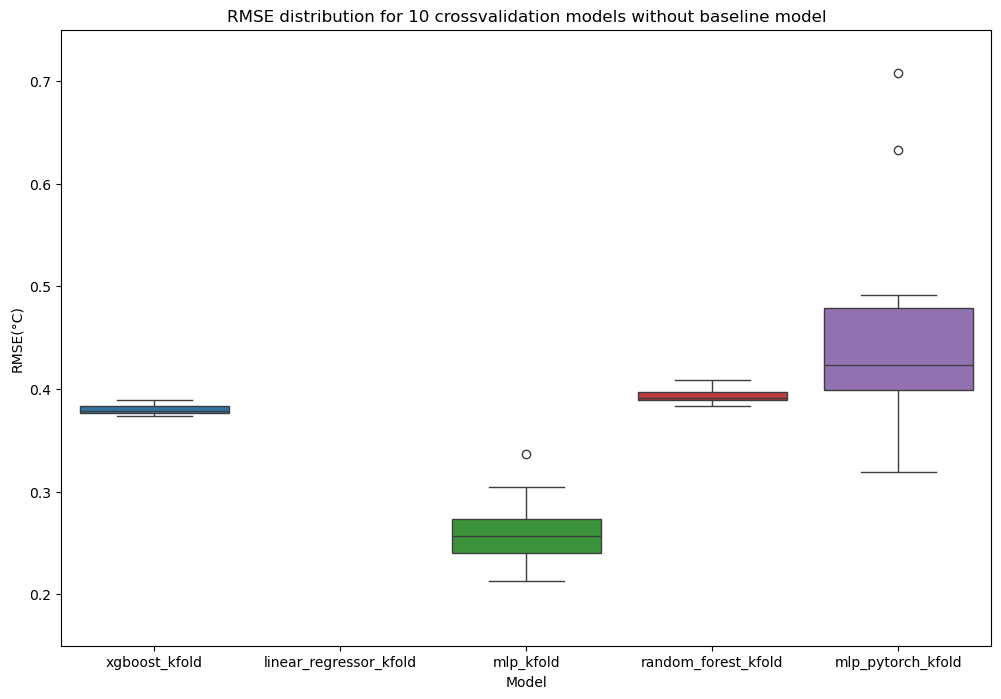

In [71]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=rmse_df)
plt.title('RMSE distribution for 10 crossvalidation models without baseline model')
plt.xlabel('Model')
plt.ylabel('RMSE(°C)')
plt.ylim(0.15, 0.75)  # Set y-axis limit for better visualization
plt.show()


# Final test running best performing model on completely unseen data

In [29]:
sweep_config = {
    'name': 'Best_model',
    'method': 'grid',  
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'n_estimators': {
            'values': [50]
        },
        'max_depth': {
            'values': [13]
        },
    }
}

def train():
    best_mse = float('inf')  
    
    with wandb.init( entity='LukaszGawenda', name = 'xgboost') as run:
        config = wandb.config
        run_name = f"xgboost max_depth_{config.max_depth}_n_estimators_{config.n_estimators}"
        wandb.run.name = run_name
       
     
        pipeline = Pipeline([
            ('scaler', StandardScaler()), 
            ('xgb', XGBRegressor(
                n_estimators=config.n_estimators,
                max_depth=config.max_depth,
                random_state=42
            ))
        ])

        pipeline.fit(X_train, y_train)
        xgb_predictions = pipeline.predict(X_validation)
           
        if pet_temp == True:
            xgb_predictions += temp_validation
        mse = mean_squared_error(y_validation, xgb_predictions)
        rmse = root_mean_squared_error(y_validation, xgb_predictions)
        with open('best_xgb_model.pkl', 'wb') as model_file:
            pickle.dump(pipeline, model_file)
        print("Model saved as 'best_xgb_model.pkl'")
        # Load and test model
        with open('best_xgb_model.pkl', 'rb') as model_file:
            pipeline = pickle.load(model_file)

        xgb_test_predictions = pipeline.predict(X_test)

        if pet_temp:
            xgb_test_predictions += temp_test
        mse_test = mean_squared_error(y_test, xgb_test_predictions)
        rmse_test = mse_test ** 0.5
        print(f"Test MSE: {mse_test}, Test RMSE: {rmse_test}")

        plot_actual_vs_predicted(y_test, 'xgb', xgb_test_predictions, 'PET')

        # Log metrics
        wandb.log({
        
            'rmse': rmse_test,
            'val_loss': mse_test  
        })

        best_mse = save_and_log_best_predictions(run, mse_test, mse_test, xgb_test_predictions, 'xgb')

        print(f"Logged an artifact: XGBoost model with MSE: {mse_test}, RMSE: {rmse_test}")


sweep_id = wandb.sweep(sweep_config, project=project_name)

Create sweep with ID: ckt5bihw
Sweep URL: https://wandb.ai/LukaszGawenda/thesis_26.04.2024_pet_manual%20split/sweeps/ckt5bihw


wandb: Agent Starting Run: txaimobr with config:
wandb: 	max_depth: 13
wandb: 	n_estimators: 50
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model saved as 'best_xgb_model.pkl'
Test MSE: 0.044655077176598605, Test RMSE: 0.21131747958131292


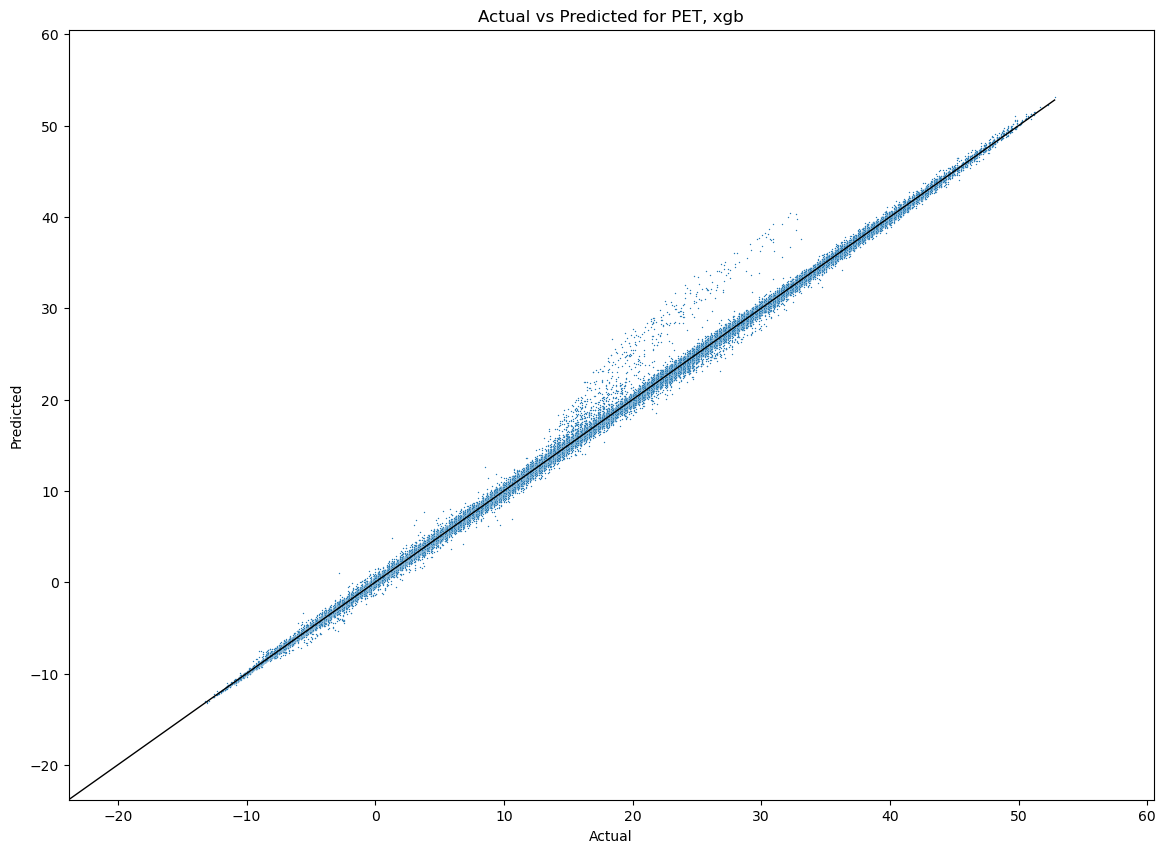

Logged an artifact: XGBoost model with MSE: 0.044655077176598605, RMSE: 0.21131747958131292


rmse,▁
val_loss,▁
rmse,0.21132
val_loss,0.04466


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [30]:
wandb.agent(sweep_id, function=train)